# Nowcasting evaluation metrics and visualization

This notebook helps visualize nowcasting outputs as well produce evaluation metrics to compare various methods. As of now, the model outputs are directly loaded from saved files (h5), however, in the future we want to be able to generate outputs for all models within this repository itself. This will remove dependence on any external code. 



Last edited: Feb 15, 2024
Author: Akshay Aravamudan

## Load the data

The following cell will load the test data from saved h5 files. The final line in this notebook is designed to fetch the input data associated with the each of the output data samples. Essentially, for each output sequence of 12 images, it fetches the preceding 12 images to act as inputs. This is done by cross-referencing the timestamps. 

In [ ]:
from data_provider import ImergDataset

imerg_filename = "data/ghana_imerg_2011_2020_Oct.h5"
ir_filename = ""
start_index = 0
end_index = 10
forecast_steps = 12
history_steps = 12
dataset = ImergDataset(imerg_filename, ir_filename, start_index, end_index, forecast_steps, history_steps, normalize_data=False)
print(dataset.input_precipitation.shape)
print(dataset.output_precipitation.shape)


: 

In [2]:
from data_processor import get_precipitation_timestamps


dgmr_imgs, dgmr_sample_datetimes = get_precipitation_timestamps(filename='data/DGMR.h5', model_type='DGMR')

# imerg_relu_mse_imgs, _ = get_precipitation_timestamps(filename='data/imerg_only_mse_relu_predictions.h5', model_type="ConvLSTM + Relu")
# imerg_mse_imgs, _ = get_precipitation_timestamps(filename='data/imerg_only_mse_predictions.h5', model_type="ConvLSTM")
# # imerg_cfss_mse_imgs, _ = get_precipitation_timestamps(filename='data/imerg_only_cfsss_log_predictions.h5', model_type="ConvLSTM + CFSSS")
# imerg_2channel_mse_imgs, _ = get_precipitation_timestamps(filename='data/imerg01r_gtIR01r_SepFalse_L2ch_predictions.h5', model_type="ConvLSTM + 2channel")


# # imerg01r_gtIR01r_SepFalse_L2ch_predictions.h5
# imerg_naive_imgs, _ = get_precipitation_timestamps(filename='data/imerg_naive_predictions.h5', model_type="naive")
# imerg_lagrangian_imgs, _ = get_precipitation_timestamps(filename='data/imerg_lagrangian_predictions.h5', model_type="lagrangian")

# imerg_inputs_imgs = get_gt_input_data(test_sample_datetimes, expected_shape=gt_imgs.shape)

Shape of DGMR outputs: (1469, 12, 1, 64, 64) 


## Generate Outputs for Baseline Models

The following cell produces outputs for naive persistence, lagrangian persistence, LINDA and PySteps. The code has been parallelized using dask so that these nowcasting estimates can be produced in parallel. It is therefore suggested to run the following code on a mutli-core CPU (or multi node HPC), although it will still run on single core CPUs.

In [3]:
from extrapolation_methods import generate_outputs

generate_outputs(dataset.input_precipitation, 
                 dataset.input_precipitation.shape,   
                 models = ['naive'], 
                 use_dask=False)
                #  models = ['steps', 'linda', 'lagrangian', 'naive'])


ModuleNotFoundError: No module named 'pysteps'

In [ ]:
from extrapolation_methods import steps,linda

res = linda(imerg_inputs_imgs[0], 12)
print(res.shape)


Pysteps configuration file found at: /home/akshay/.pysteps/pystepsrc

Computing LINDA nowcast
-----------------------

Inputs
------
dimensions:           360x516
number of time steps: 12

Methods
-------
nowcast type:         deterministic
feature detector:     blob
extrapolator:         semilagrangian
kernel type:          anisotropic

Parameters
----------
number of time steps:       12
ARI model order:            1
localization window radius: 72.0

Detecting features... found 15 blobs.
Transforming to Lagrangian coordinates... done.
Estimating the first convolution kernel... done.
Estimating the ARI(p,1) parameters... done.
Estimating the second convolution kernel... done.
Computing nowcast for time step 1... done.
Computing nowcast for time step 2... done.
Computing nowcast for time step 3... done.
Computing nowcast for time step 4... done.
Computing nowcast for time step 5... done.
Computing nowcast for time step 6... done.
Computing nowcast for time step 7... done.
Computing now

## Process metrics

In [ ]:
import numpy as np



conv_lstm_fss = [[] for _ in range(12)]
conv_lstm_relu_fss = [[] for _ in range(12)]
naive_fss = [[] for _ in range(12)]


conv_lstm_mse = [[] for _ in range(12)]

conv_lstm_relu_mse = [[] for _ in range(12)]
naive_fss_mse = [[] for _ in range(12)]

# steps_fss = [[] for _ in range(12)]
# linda_fss = [[] for _ in range(12)]

from core import FSS, MSE


forecast_horizon = 12

num_samples = gt_imgs.shape[0]

FSS_threshold = 8
FSS_n=1

for sample_index in range(num_samples):
    print("Processed {} image sequences out of {}".format(sample_index, num_samples), end='\r')
    for j in range(forecast_horizon):
        FSS_conv_lstm_sample = FSS(imerg_mse_imgs[sample_index][j], 
                                   gt_imgs[sample_index][j], threshold=FSS_threshold, n=FSS_n)
        MSE_conv_lstm_sample = MSE(imerg_mse_imgs[sample_index][j], gt_imgs[sample_index][j])
        FSS_conv_lstm_relu_sample = FSS(imerg_relu_mse_imgs[sample_index][j], 
                                   gt_imgs[sample_index][j], threshold=FSS_threshold, n=FSS_n)
        MSE_conv_lstm_relu_sample = MSE(imerg_relu_mse_imgs[sample_index][j], gt_imgs[sample_index][j])
        FSS_naive_sample = FSS(imerg_naive_imgs[sample_index][j], 
                               gt_imgs[sample_index][j], threshold=FSS_threshold, n=FSS_n)
        MSE_naive_sample = MSE(imerg_naive_imgs[sample_index][j], gt_imgs[sample_index][j])
        
        
        if not np.isnan(FSS_conv_lstm_sample).any():
            conv_lstm_fss[j].append(FSS_conv_lstm_sample)
        if not np.isnan(FSS_conv_lstm_relu_sample).any():
            conv_lstm_relu_fss[j].append(FSS_conv_lstm_relu_sample)
        if not np.isnan(FSS_naive_sample).any():
            naive_fss[j].append(FSS_naive_sample)
        
        
        conv_lstm_mse[j].append(MSE_conv_lstm_sample)
        conv_lstm_relu_mse[j].append(MSE_conv_lstm_relu_sample)
        naive_fss_mse[j].append(MSE_naive_sample)



            

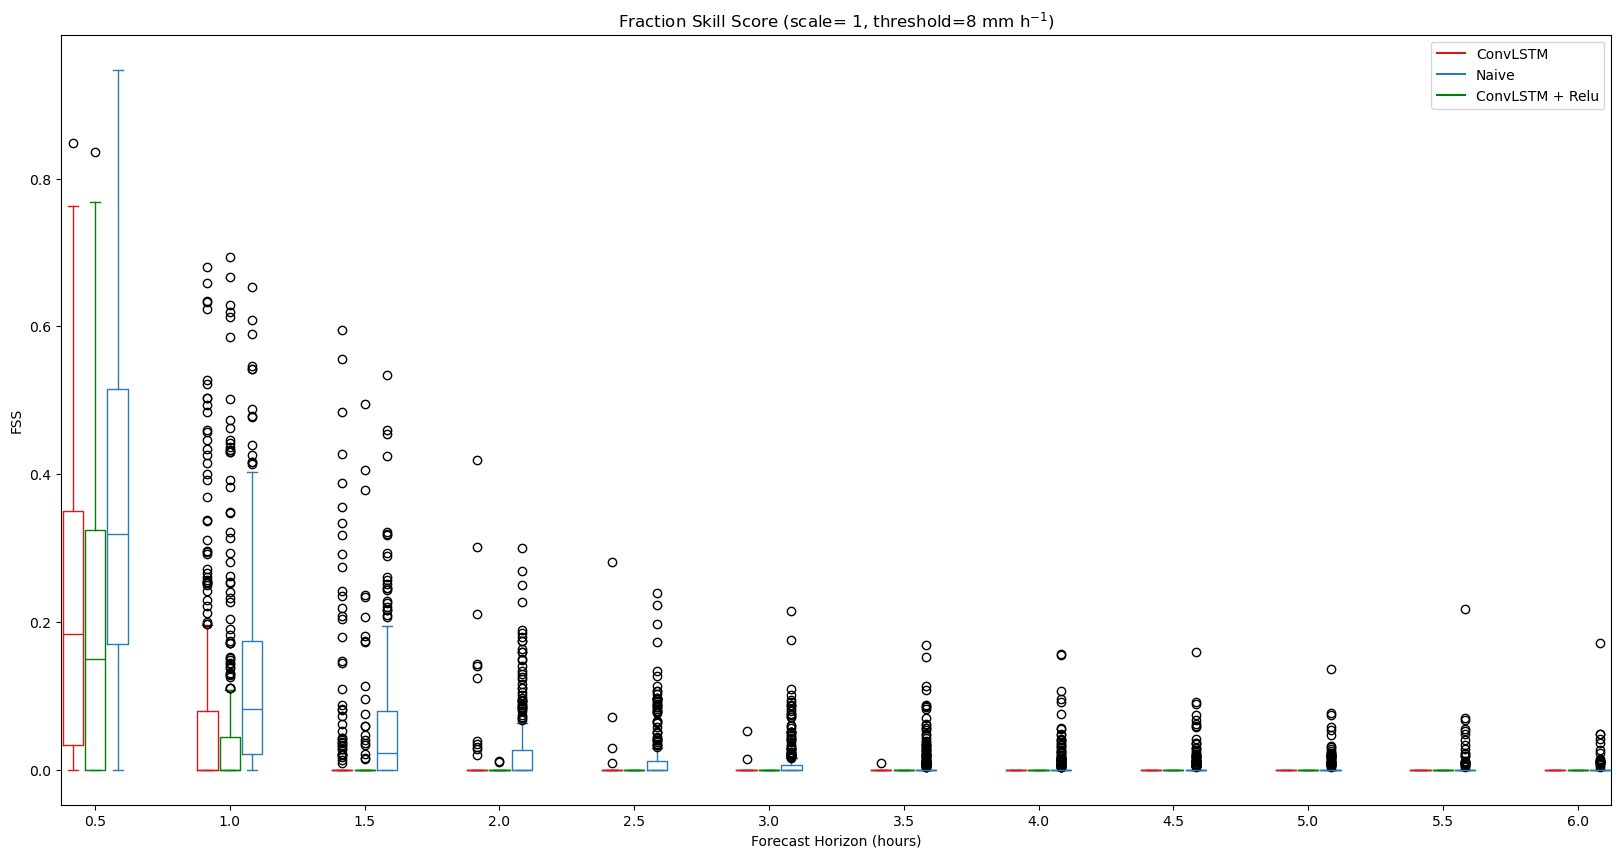

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(figsize=(20,10)) 
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

for i in range(12):
    # sns.boxplot(x = i*np.ones_like(vals[i]), y = vals[i])
    bp_cnv_lstm = plt.boxplot([conv_lstm_fss[i]],widths = 0.9,  positions=[0+i*6])
    set_box_color(bp_cnv_lstm, '#D7191C')
    bp_lagrangian = plt.boxplot([conv_lstm_relu_fss[i]],widths = 0.9,  positions=[1+i*6])
    set_box_color(bp_lagrangian, '#008000')
    bp_naive = plt.boxplot([naive_fss[i]],widths = 0.9,  positions=[2+i*6])
    set_box_color(bp_naive, '#2C7BB6')
    
    # ,naive_fss[i], 
                #  lagrangian_fss[i],1+i*3, 2+i*3
     # colors are from http://colorbrewer2.org/
    # set_box_color(bpr, '#')
plt.xticks(range(1, 12 * 6 + 1, 6), [str(i/2 + 0.5) for i in range(12)])
plt.plot([], c='#D7191C', label='ConvLSTM')
plt.plot([], c='#2C7BB6', label='Naive')
plt.plot([], c='#008000', label='ConvLSTM + Relu')

plt.xlabel("Forecast Horizon (hours)")
plt.ylabel("FSS")
plt.title("Fraction Skill Score (scale= "+str(FSS_n)+", threshold="+str(FSS_threshold)+" mm h$^{-1}$)")


plt.legend()

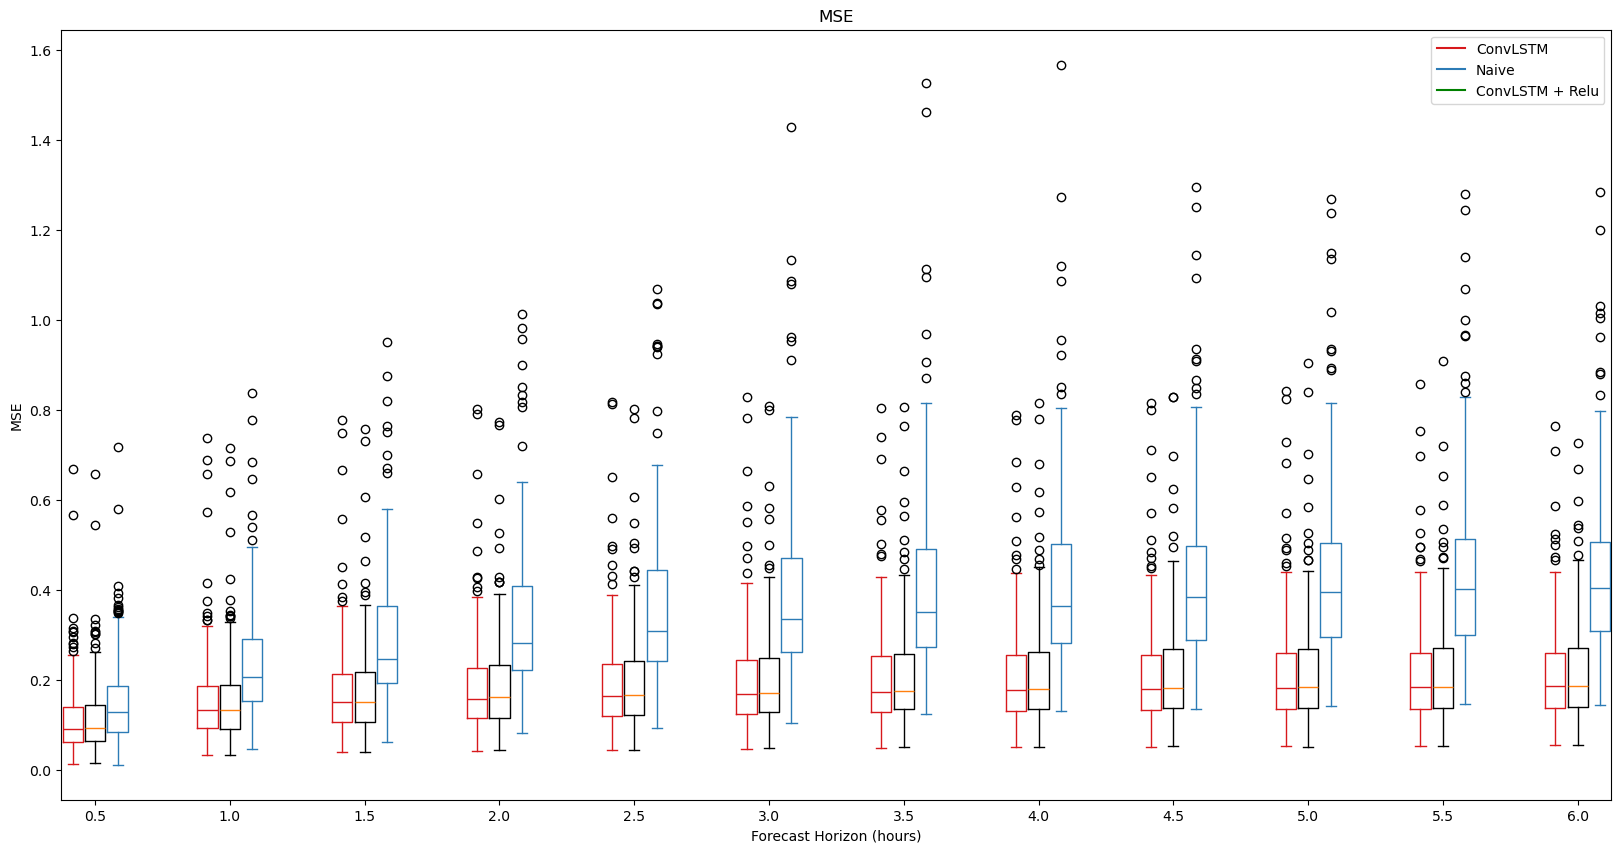

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(figsize=(20,10)) 
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
for i in range(12):
    # sns.boxplot(x = i*np.ones_like(vals[i]), y = vals[i])
    bp_cnv_lstm = plt.boxplot([conv_lstm_mse[i]],widths = 0.9,  positions=[0+i*6])
    set_box_color(bp_cnv_lstm, '#D7191C')
    bp_cnv_lstm_relu = plt.boxplot([conv_lstm_relu_mse[i]],widths = 0.9,  positions=[1+i*6])
    set_box_color(bp_lagrangian, '#008000')
    bp_naive = plt.boxplot([naive_fss_mse[i]],widths = 0.9,  positions=[2+i*6])
    set_box_color(bp_naive, '#2C7BB6')
    
    # ,naive_fss[i], 
                #  lagrangian_fss[i],1+i*3, 2+i*3
     # colors are from http://colorbrewer2.org/
    # set_box_color(bpr, '#')
plt.xticks(range(1, 12 * 6 + 1, 6), [str(i/2 + 0.5) for i in range(12)])
plt.plot([], c='#D7191C', label='ConvLSTM')
plt.plot([], c='#2C7BB6', label='Naive')
plt.plot([], c='#008000', label='ConvLSTM + Relu')

plt.xlabel("Forecast Horizon (hours)")
plt.ylabel("MSE")
plt.title("MSE")


plt.legend()

Create Plots for visualization

In [ ]:
import matplotlib
plt.clf()
global_min_non_zero_precipitation_intensity = 1.0 # mm/h
global_max_precipitation_intensity = 20.0 # mm/h

img_size = (64,64)
cmap_custom = matplotlib.cm.jet

# Use white color for pixels whose intensity is below 
# global_min_non_zero_precipitation_intensity.
# Use pink color for pixels whose intensity is above 
# global_max_precipitation_intensity.
cmap_custom.set_under('white') 
cmap_custom.set_over('pink')


fig, axarr = plt.subplots(2,12, figsize = (64, 64), gridspec_kw = {'wspace':0.05, 'hspace':-0.9})
    
image_index = 795
# fig.suptitle('Time steps $T_{'+str(captions[0])+'}$ to $T_{'+str(captions[-1])+'}$')
    
for i in range(12):
    im = axarr[0][i].imshow(gt_data[image_index][i][0], animated=False, cmap=cmap_custom)
    im = axarr[1][i].imshow(data[image_index][i][0], animated=False, cmap=cmap_custom)


cax = fig.add_axes([0.075, 0.4, 0.02, 0.18])
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=20)

for ax in axarr.flatten():
    ax.grid('on', linestyle='--')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.savefig('test.png', bbox_inches="tight")
plt.show()

plt.close()

In [ ]:
# !pip install pysteps
from pysteps.visualization import plot_precip_field


ImportError: dlopen(/Users/akshayaravamudan/anaconda3/envs/akshay_env/lib/python3.9/site-packages/rpds/rpds.cpython-39-darwin.so, 0x0002): tried: '/Users/akshayaravamudan/anaconda3/envs/akshay_env/lib/python3.9/site-packages/rpds/rpds.cpython-39-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/akshayaravamudan/anaconda3/envs/akshay_env/lib/python3.9/site-packages/rpds/rpds.cpython-39-darwin.so' (no such file), '/Users/akshayaravamudan/anaconda3/envs/akshay_env/lib/python3.9/site-packages/rpds/rpds.cpython-39-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64'))

## GAN  experiments comparison  

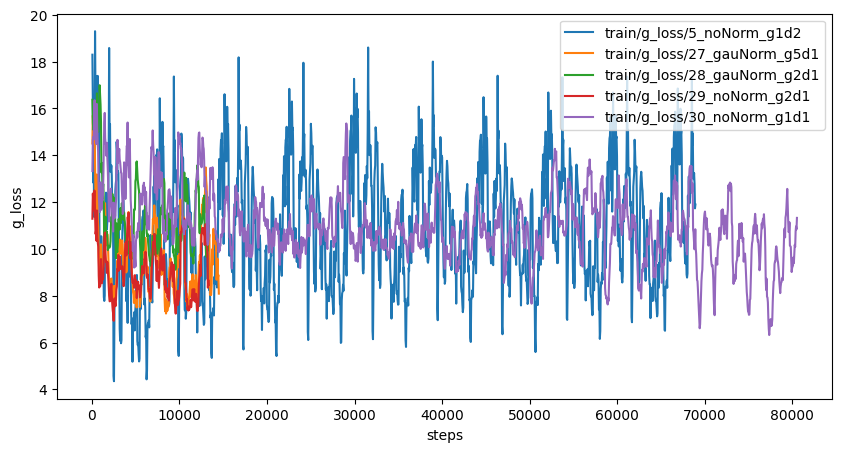

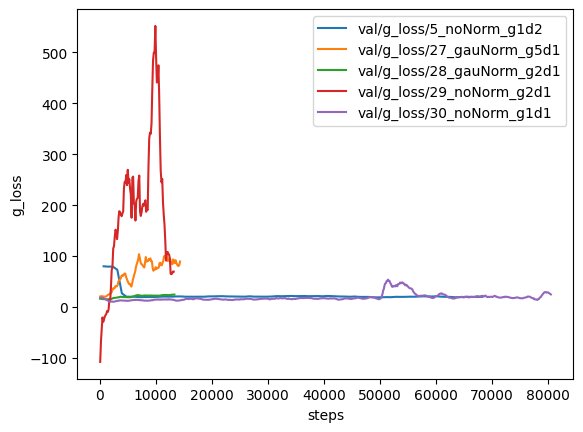

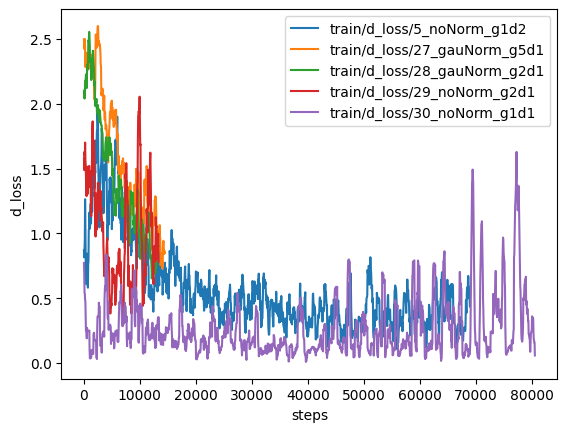

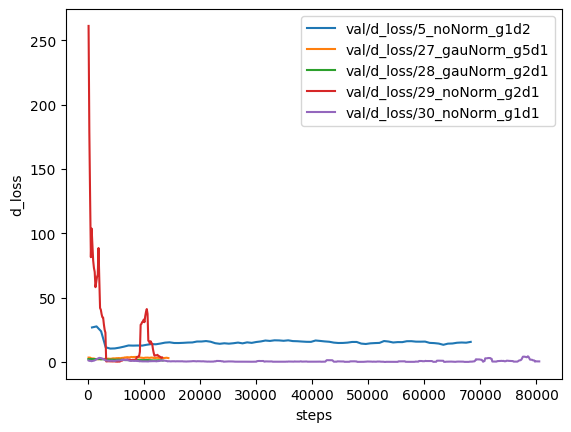

In [16]:
import pandas as pd
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np

## from: https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

dir = 'data/results/metrics_ver'
files = ['5_noNorm_g1d2','27_gauNorm_g5d1','28_gauNorm_g2d1','29_noNorm_g2d1','30_noNorm_g1d1']

# plot the train/g_loss 
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0])

for loss in ['g_loss', 'd_loss']:
    for dataset in ['train', 'val']:
        for filename in files:
            log_df = pd.read_csv(dir + filename + '.csv')
            sub_df = log_df.dropna(subset=[dataset+'/' + loss])
            x = sub_df['step'].values
            y = sub_df[dataset+'/'+loss].values
            y_ave = moving_average(y, 10)  ## moving average
            x_ave = np.arange(x[0], x[-1], x[-1]/y_ave.shape[0]) ## compensate for shorter signal 

            # plt.plot(sub_df['epoch'].dropna(), sub_df['train/d_loss'], label='train/d_loss')
            plt.plot(x_ave,y_ave, label=dataset+'/'+loss + '/' + filename)
            # plt.plot(x,y, label=dataset+'/'+loss +'/' + filename , alpha = 0.5)
        plt.xlabel('steps')
        plt.ylabel(loss)
        plt.legend()
        plt.savefig('data/results/'+dataset+'_' + loss+'.png')
        plt.show()
